In [1]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

import tensorflow as tf

%matplotlib inline

In [2]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [3]:
class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512                # lvl1 nodes
        self.d = 4096               # lvl1 receptive field

        num_regions  = 1 + (self.window-self.d)/self.stride
        
        print 'Lvl1 regions: {}'.format(num_regions)
        
        d2_x = 1
        d2_y = 128
        k2 = 128
        stride_y = 2
        
        d3_x = 25 # lvl3 input dims_x
        d3_y = 1 # lvl3 input dims_y (fully connected)
        k3 = 256 # num lvl3 filters
        
        num_regions  = 1 + (self.window-self.d)/self.stride
        #print 'First layer regions: ({},{})'.format(num_regions,self.k)
        num_regions2_x  = 1 + (num_regions-d2_x)/1
        num_regions2_y = 1 + (self.k-d2_y)/stride_y
        #print 'Second layer regions: ({},{})'.format(num_regions2_x,num_regions2_y)
        num_regions3_x = 1 + (num_regions2_x - d3_x)/1
        num_regions3_y = 1 + (num_regions2_y - d3_y)/1

        print '---- Weights ----'
        wscale = 10e-3
        with tf.variable_scope('parameters'):
            w = tf.Variable(wscale*tf.random_normal([1,self.d,1,self.k],seed=999))
            print 'w',w
            wavg = self.register_weights(w,'w',average=.9998)
            w1 = tf.Variable(wscale*tf.random_normal([d2_x,d2_y,1,k2],seed=999))
            print 'w1',w1
            w1avg = self.register_weights(w1,'w1',average=.9998)
            w2 = tf.Variable(wscale*tf.random_normal([d3_x,d3_y,k2,k3],seed=999))
            print 'w2',w2
            w2avg = self.register_weights(w2,'w2',average=.9998)
            beta = tf.Variable(wscale*tf.random_normal([num_regions3_x*num_regions3_y*k3,self.m],seed=999))
            print 'beta',beta
            betaavg = self.register_weights(beta,'beta',average=.9998)

        print '---- Layers ----'
        with tf.variable_scope('queued_model'):
            zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(self.xq,w,strides=[1,1,self.stride,1],padding='VALID')))
            print 'zx',zx
            z2 = tf.nn.relu(tf.nn.conv2d(zx,w1,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
            print 'z2',z2
            z3 = tf.nn.relu(tf.nn.conv2d(z2,w2,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
            print 'z3',z3
            y = tf.matmul(tf.reshape(z3,[self.batch_size,num_regions3_x*num_regions3_y*k3]),beta)
            print 'y',y
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(self.xd,wavg,strides=[1,1,self.stride,1],padding='VALID')))
            z2 = tf.nn.relu(tf.nn.conv2d(zx,w1avg,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
            z3 = tf.nn.relu(tf.nn.conv2d(z2,w2avg,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
            self.y_direct = tf.matmul(tf.reshape(z3,[tf.shape(self.xd)[0],num_regions3_x*num_regions3_y*k3]),betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [4]:
try: model.stop()
except NameError: pass
model = Spectrograms(labels,checkpoint_path='convnet_experimental2_raw/', outputs=1, window=16384, mmap=True, batch_size=100,
                     normalize=True, extended_test_set=True, use_mirex=True, init=False, pitch_transforms=5, jitter=.1,
                     restrict=True)

Lvl1 regions: 25
---- Weights ----
w <tf.Variable 'parameters/Variable:0' shape=(1, 4096, 1, 512) dtype=float32_ref>
w1 <tf.Variable 'parameters/Variable_2:0' shape=(1, 128, 1, 128) dtype=float32_ref>
w2 <tf.Variable 'parameters/Variable_4:0' shape=(25, 1, 128, 256) dtype=float32_ref>
beta <tf.Variable 'parameters/Variable_6:0' shape=(49408, 93) dtype=float32_ref>
---- Layers ----
zx Tensor("queued_model/Log:0", shape=(100, 1, 25, 512), dtype=float32)
z2 Tensor("queued_model/Relu_1:0", shape=(100, 128, 25, 193), dtype=float32)
z3 Tensor("queued_model/Relu_2:0", shape=(100, 256, 1, 193), dtype=float32)
y Tensor("queued_model/MatMul:0", shape=(100, 93), dtype=float32)


In [48]:
lr = 10e-4/2./2/2/2/2
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 10000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    print 'Graceful Exit'

# avp_test  avp_train  mse_test  mse_train  time  utime
# 0.509154  0.511357   1.171773  1.453633   11    11     

Lvl1 regions: 25
---- Weights ----
w <tf.Variable 'parameters/Variable:0' shape=(1, 4096, 1, 512) dtype=float32_ref>
w1 <tf.Variable 'parameters/Variable_2:0' shape=(1, 128, 1, 128) dtype=float32_ref>
w2 <tf.Variable 'parameters/Variable_4:0' shape=(25, 1, 128, 256) dtype=float32_ref>
beta <tf.Variable 'parameters/Variable_6:0' shape=(49408, 93) dtype=float32_ref>
---- Layers ----
zx Tensor("queued_model/Log:0", shape=(100, 1, 25, 512), dtype=float32)
z2 Tensor("queued_model/Relu_1:0", shape=(100, 128, 25, 193), dtype=float32)
z3 Tensor("queued_model/Relu_2:0", shape=(100, 256, 1, 193), dtype=float32)
y Tensor("queued_model/MatMul:0", shape=(100, 93), dtype=float32)
avp_test	avp_train	mse_test	mse_train	time	utime
0.731866        0.742900        0.552159        0.662046        24      24      
0.731535        0.742970        0.552241        0.662027        477     24      
0.731191        0.742966        0.552544        0.662166        477     24      
0.731286        0.743162        0

0.732052216474
0.551977709133


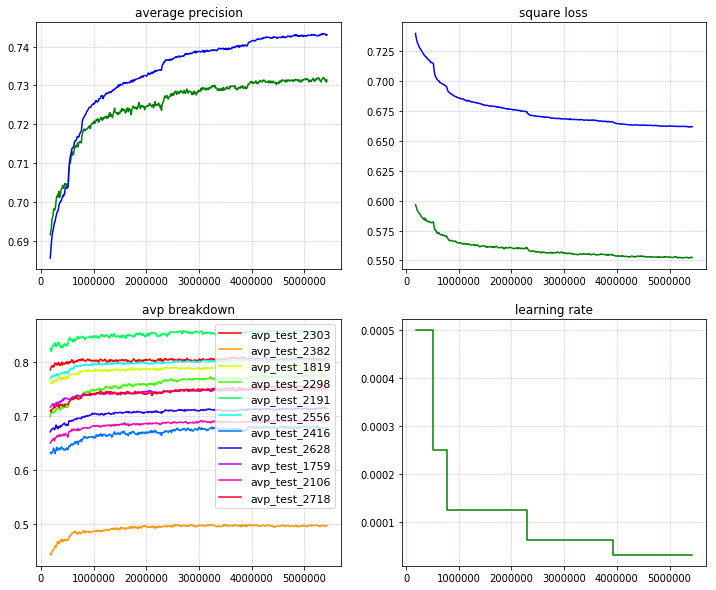

In [49]:
burnin=20
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('avp breakdown')
ax3.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
cmap = plt.cm.get_cmap('hsv',len(model.test_ids))
plots = []
keys = []
for i,rec_id in enumerate(model.test_ids):
    plot, = ax3.plot(model.stats['iter'][2][burnin:], model.stats['avp_test_' + str(rec_id)][2][burnin:], color=cmap(i))
    plots.append(plot)
    keys.append('avp_test_' + str(rec_id))
leg = ax3.legend(plots,keys,loc='upper right',ncol=1,prop={'size':11})
ax4.set_title('learning rate')
ax4.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')

print max(model.stats['avp_test'][2])
print min(model.stats['mse_test'][2])

# Mirex stats

In [5]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.733640288246


In [6]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.57	75.68	76.69	0.62	0.39	0.09	0.15	0.16
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
49.81	55.56	45.29	0.33	0.75	0.16	0.38	0.20
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.94	73.70	70.68	0.56	0.45	0.09	0.20	0.16
0.504057951317 0.530727941417


# Extended test set stats

In [7]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.745707285268


In [8]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.57	75.68	76.69	0.62	0.39	0.09	0.15	0.16
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
49.81	55.56	45.29	0.33	0.75	0.16	0.38	0.20
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.94	73.70	70.68	0.56	0.45	0.09	0.20	0.16
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
77.51	72.20	70.45	0.55	0.42	0.15	0.15	0.12
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
85.48	73.74	84.71	0.65	0.34	0.12	0.04	0.19
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.14	75.17	76.84	0.61	0.38	0.11	0.12	0.15
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
67.78	59.31	75.19	0.50	0.67	0.09	0.15	0.42
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
71.41	69.07	66.62	0.51	0.50	0.13	0.21	0.17
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
74.90	70.52	74.70	0.57	0.44	0.12	0.13	0.19
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
69.05	70.13	62.13	0.49	0.49	0.15	0.23	0.11
0.539966307185 0.483388782374
